# Our Notebook

In [2]:
"""
Get data from Open-meteo and store it locally.
"""

import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry
import time

# read city location data
power_consumption_data = pd.read_csv('../power_consumption_data.csv')
cities_with_coordinates = power_consumption_data[['City', 'Coordinates']]


# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"

responses = {}

for index, row in cities_with_coordinates.iterrows():
	params = {
		"latitude": float(row['Coordinates'].split(",")[0]),
		"longitude": float(row['Coordinates'].split(",")[1]),
		"start_date": "2021-01-01",
		"end_date": "2024-01-01",
		"hourly": ["temperature_2m", "precipitation", "cloud_cover", "sunshine_duration", "terrestrial_radiation"]
	}
	responses[row['City']] = openmeteo.weather_api(url, params=params)

	#responses.append(openmeteo.weather_api(url, params=params))
	# sleep for 10 seconds to not overwhelm the API calls e.g.
	# Minutely API request limit exceeded. Please try again in one minute.
	time.sleep(10)

print(responses)

hourly_dataframe = pd.DataFrame()
# Process first location. Add a for-loop for multiple locations or weather models
# response = responses[0][0]
for city, resp in responses.items():
	response = resp[0]
	print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
	print(f"Elevation {response.Elevation()} m asl")
	print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
	print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

	# Process hourly data. The order of variables needs to be the same as requested.
	hourly = response.Hourly()
	hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
	hourly_precipitation = hourly.Variables(1).ValuesAsNumpy()
	hourly_cloud_cover = hourly.Variables(2).ValuesAsNumpy()
	hourly_sunshine_duration = hourly.Variables(3).ValuesAsNumpy()
	hourly_terrestrial_radiation = hourly.Variables(4).ValuesAsNumpy()

	print("stuff")
	hourly_data = {
		"date": pd.date_range(
		start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
		end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
		freq = pd.Timedelta(seconds = hourly.Interval()),
		inclusive = "left"
	)}

	hourly_data["temperature_2m"] = hourly_temperature_2m
	hourly_data["precipitation"] = hourly_precipitation
	hourly_data["cloud_cover"] = hourly_cloud_cover
	hourly_data["sunshine_duration"] = hourly_sunshine_duration
	hourly_data["terrestrial_radiation"] = hourly_terrestrial_radiation
	hourly_data["city"] = city

	df = pd.DataFrame(data = hourly_data)
	hourly_dataframe = pd.concat([hourly_dataframe, df], ignore_index=True)
print(hourly_dataframe)


hourly_dataframe.to_csv("cities_data_hourly.csv", index = False)



{'Berlin': [<openmeteo_sdk.WeatherApiResponse.WeatherApiResponse object at 0x0000025719F61810>], 'Paris': [<openmeteo_sdk.WeatherApiResponse.WeatherApiResponse object at 0x0000025719EE3F70>], 'London': [<openmeteo_sdk.WeatherApiResponse.WeatherApiResponse object at 0x0000025719EE3730>], 'Rome': [<openmeteo_sdk.WeatherApiResponse.WeatherApiResponse object at 0x0000025719F605E0>], 'Madrid': [<openmeteo_sdk.WeatherApiResponse.WeatherApiResponse object at 0x0000025719F606A0>], 'Warsaw': [<openmeteo_sdk.WeatherApiResponse.WeatherApiResponse object at 0x0000025719F606D0>], 'Moscow': [<openmeteo_sdk.WeatherApiResponse.WeatherApiResponse object at 0x0000025719F607F0>], 'Istanbul': [<openmeteo_sdk.WeatherApiResponse.WeatherApiResponse object at 0x0000025719F60940>], 'Amsterdam': [<openmeteo_sdk.WeatherApiResponse.WeatherApiResponse object at 0x0000025719F609A0>], 'Brussels': [<openmeteo_sdk.WeatherApiResponse.WeatherApiResponse object at 0x0000025719F62CE0>], 'Athens': [<openmeteo_sdk.WeatherAp

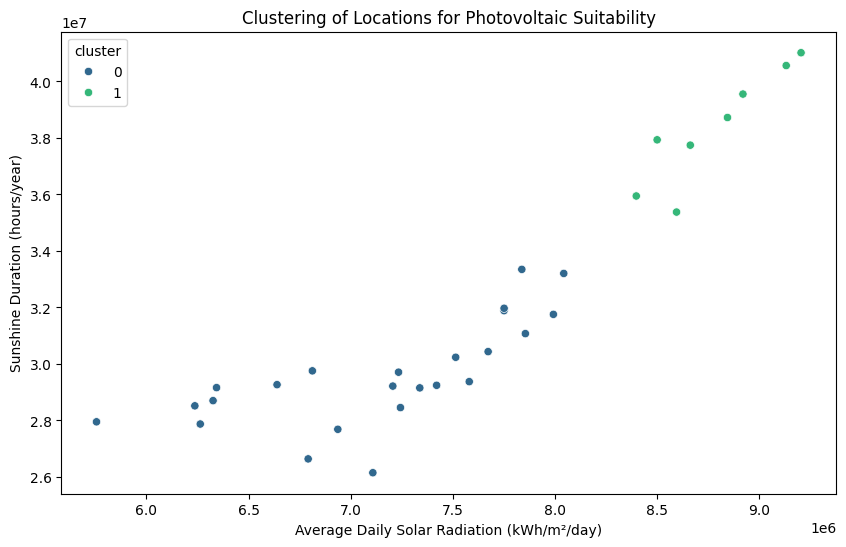

       location pv_suitability
0        Berlin            Bad
1         Paris            Bad
2        London            Bad
3          Rome           Good
4        Madrid           Good
5        Warsaw            Bad
6        Moscow            Bad
7      Istanbul           Good
8     Amsterdam            Bad
9      Brussels            Bad
10       Athens           Good
11       Vienna            Bad
12       Prague            Bad
13     Budapest            Bad
14    Stockholm            Bad
15   Copenhagen            Bad
16         Oslo            Bad
17       Zurich            Bad
18       Lisbon           Good
19       Dublin            Bad
20        Sofia           Good
21   Bratislava            Bad
22       Zagreb            Bad
23    Ljubljana            Bad
24      Tallinn            Bad
25      Vilnius            Bad
26         Riga            Bad
27  Luxembourg             Bad
28     Helsinki            Bad
29      Nicosia           Good
30     Valletta           Good
31    Re

In [10]:
#### Step 1: Import necessary libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# For demonstration, assume we have a DataFrame `weather_data` with necessary columns
weather_data = pd.read_csv('../../../models/data/cities_data_yearly.csv')




#### Step 2: Data Preprocessing
# Normalize the data
scaler = StandardScaler()
weather_features = weather_data[
    ['terrestrial_radiation', 'cloud_cover', 'sunshine_duration', 'temperature_2m', 'precipitation']]
weather_features_scaled = scaler.fit_transform(weather_features)

#### Step 3: Apply Clustering
# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(weather_features_scaled)

# Add the cluster labels to the original DataFrame
weather_data['cluster'] = clusters

#### Step 4: Evaluate and Visualize Clusters
# Visualize the clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=weather_data, x='terrestrial_radiation', y='sunshine_duration', hue='cluster',
                palette='viridis')
plt.title('Clustering of Locations for Photovoltaic Suitability')
plt.xlabel('Average Daily Solar Radiation (kWh/m²/day)')
plt.ylabel('Sunshine Duration (hours/year)')
plt.show()

# Label clusters as good or bad spots
cluster_centers = kmeans.cluster_centers_
good_cluster = np.argmax(cluster_centers[:, 0])  # Assuming higher solar radiation is better
weather_data['pv_suitability'] = weather_data['cluster'].apply(lambda x: 'Good' if x == good_cluster else 'Bad')
print(weather_data[['location', 'pv_suitability']])


In [11]:
weather_data.groupby('cluster')['cloud_cover'].mean()

cluster
0    53.657174
1    29.119331
Name: cloud_cover, dtype: float64

In [12]:
weather_data.columns

Index(['terrestrial_radiation', 'cloud_cover', 'temperature_2m',
       'precipitation', 'sunshine_duration', 'location', 'cluster',
       'pv_suitability'],
      dtype='object')

In [13]:
weather_data.groupby('cluster')[['terrestrial_radiation', 'cloud_cover', 'temperature_2m',
       'precipitation', 'sunshine_duration']].mean()

,terrestrial_radiation,cloud_cover,temperature_2m,precipitation,sunshine_duration
cluster,,,,,
0,7.152873e+06,53.657174,9.747712,2506.054167,2.961634e+07
1,8.783623e+06,29.119331,16.883051,1740.412500,3.835743e+07


In [15]:
weather_data[weather_data['location']== 'Berlin']


,terrestrial_radiation,cloud_cover,temperature_2m,precipitation,sunshine_duration,location,cluster,pv_suitability
0,7.206783e+06,54.688637,10.700287,1982.9,2.921755e+07,Berlin,0,Bad


In [16]:
!pip install -r /content/requirements.txt


ERROR: Could not open requirements file: [Errno 2] No such file or directory: '/content/requirements.txt'
